In [1]:
import jax.numpy as jnp
import jax
import numpy as np
from fbpinns.problems import Problem

class KovasznayFlow(Problem):
    """
    Solves the steady 2D incompressible Navier–Stokes equations (momentum + continuity)
    via the Kovasznay flow, defined on the domain [0,1] x [0,1].

    The equations are:
        u u_x + v u_y + p_x - ν (u_{xx}+u_{yy}) = 0,
        u v_x + v v_y + p_y - ν (v_{xx}+v_{yy}) = 0,
        u_x + v_y = 0,
    where ν is the kinematic viscosity.

    The exact solution is given by:
        u(x,y) = 1 - e^(λ x) cos(2π y),
        v(x,y) = (λ/(2π)) e^(λ x) sin(2π y),
        p(x,y) = ½ (1 - e^(2λ x)),
    with
        λ = Re/2 - sqrt((Re/2)^2+4π²),
        Re = 1/ν.
        
    For example, for Re=40 (ν=0.025) we have λ ≈ -0.952.
    
    We enforce the boundary conditions by reparameterizing the solution:
      u(x,y) = M(x,y)*N_u(x,y) + u_exact(x,y),
      v(x,y) = M(x,y)*N_v(x,y) + v_exact(x,y),
      p(x,y) = N_p(x,y) + p_exact(x,y),
    where M(x,y)=x(1-x)y(1-y) vanishes on ∂([0,1]×[0,1]).
    """

    @staticmethod
    def init_params(nu=0.025, sd=0.1):
        # Compute Reynolds number and λ
        Re = 1.0 / nu
        lam = Re / 2.0 - jnp.sqrt((Re/2.0)**2 + 4 * (jnp.pi**2))
        static_params = {
            "dims": (3, 2),  # 3 outputs: u, v, p; 2 inputs: x, y.
            "nu": nu,
            "lam": lam,
            "sd": sd,
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Sample interior points from the domain [0,1] x [0,1]
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        # Request second derivatives for u and v, and first derivatives for p,
        # as well as first derivatives for the divergence condition.
        # Here we request:
        #   (0, (0,)) for u_x and (0, (1,)) for u_y,
        #   (0, (0,0)) for u_xx and (0, (1,1)) for u_yy,
        #   similarly for v,
        #   (2, (0,)) for p_x and (2, (1,)) for p_y.
        # To also enforce continuity u_x+v_y=0, we use the already requested u_x and v_y.
        required_diffs = (
            (0, ()),       # u
            (0, (0,)),     # u_x
            (0, (1,)),     # u_y
            (0, (0,0)),    # u_xx
            (0, (1,1)),    # u_yy
            (1, ()),       # v
            (1, (0,)),     # v_x
            (1, (1,)),     # v_y
            (1, (0,0)),    # v_xx
            (1, (1,1)),    # v_yy
            (2, ()),       # p
            (2, (0,)),     # p_x
            (2, (1,)),     # p_y
        )
        return [[x_batch_phys, required_diffs]]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Reparameterizes the network output to enforce the boundary conditions.
        
        Let the raw network output be:
            N(x,y) = [N_u(x,y), N_v(x,y), N_p(x,y)].
        Then define the full solution as:
            u(x,y) = M(x,y)*N_u(x,y) + u_exact(x,y),
            v(x,y) = M(x,y)*N_v(x,y) + v_exact(x,y),
            p(x,y) = N_p(x,y) + p_exact(x,y),
        with the multiplier M(x,y)=x(1-x)y(1-y) which vanishes on the boundary.
        """
        x = x_batch[:, 0:1]
        y = x_batch[:, 1:2]
        sd, tanh = all_params["static"]["problem"]["sd"], jax.nn.tanh
        # M = x * (1 - x) * y * (1 - y)
        c = tanh((x)/sd) * tanh((1-x)/sd) * tanh((y)/sd) * tanh((1-y)/sd)
        
        # Extract exact solution (using lam and nu from static_params)
        lam = all_params["static"]["problem"]["lam"]
        pi = jnp.pi
        u_exact = 1 - jnp.exp(lam * x) * jnp.cos(2 * pi * y)
        v_exact = (lam / (2 * pi)) * jnp.exp(lam * x) * jnp.sin(2 * pi * y)
        p_exact = 0.5 * (1 - jnp.exp(2 * lam * x))
        
        # Split network outputs
        N_u = net_out[:, 0:1]
        N_v = net_out[:, 1:2]
        N_p = net_out[:, 2:3]
        
        u = c * N_u + u_exact
        v = c * N_v + v_exact
        p = N_p + p_exact
        return jnp.concatenate([u, v, p], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        # Retrieve the kinematic viscosity from the parameters.
        nu = all_params["static"]["problem"]["nu"]
        
        # Unpack the constraints array.
        # We assume constraints[0] contains:
        # [x_batch, u, u_x, u_y, u_xx, u_yy, v, v_x, v_y, v_xx, v_yy, p, p_x, p_y]
        (x_batch, u, u_x, u_y, u_xx, u_yy,
        v, v_x, v_y, v_xx, v_yy,
        p, p_x, p_y) = constraints[0]
        
        # Compute the momentum residuals.
        # Residual for the u-momentum equation:
        # R_u = u * u_x + v * u_y + p_x - nu*(u_xx + u_yy)
        residual_u = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        
        # Residual for the v-momentum equation:
        # R_v = u * v_x + v * v_y + p_y - nu*(v_xx + v_yy)
        residual_v = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
        
        # Compute the continuity residual:
        # R_c = u_x + v_y
        residual_c = u_x + v_y
        
        # Define the total loss as the sum of mean squared errors.
        loss_u = jnp.mean(residual_u ** 2)
        loss_v = jnp.mean(residual_v ** 2)
        loss_c = jnp.mean(residual_c ** 2)
        
        return loss_u + loss_v + loss_c


    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        Returns the exact Kovasznay flow solution:
            u(x,y) = 1 - e^(λ x) cos(2π y),
            v(x,y) = (λ/(2π)) e^(λ x) sin(2π y),
            p(x,y) = ½ (1 - e^(2λ x)).
        """
        lam = all_params["static"]["problem"]["lam"]
        pi = jnp.pi
        x = x_batch[:, 0:1]
        y = x_batch[:, 1:2]
        u = 1 - jnp.exp(lam * x) * jnp.cos(2 * pi * y)
        v = (lam / (2 * pi)) * jnp.exp(lam * x) * jnp.sin(2 * pi * y)
        p = 0.5 * (1 - jnp.exp(2 * lam * x))
        return jnp.concatenate([u, v, p], axis=1)


[INFO] 2025-03-28 02:16:19 - <fbpinns.constants.Constants object at 0x7fb3cdf08450>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.KovasznayFlow'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222]), array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222])], 'unnorm': (0.0, 3.0)}
network: <

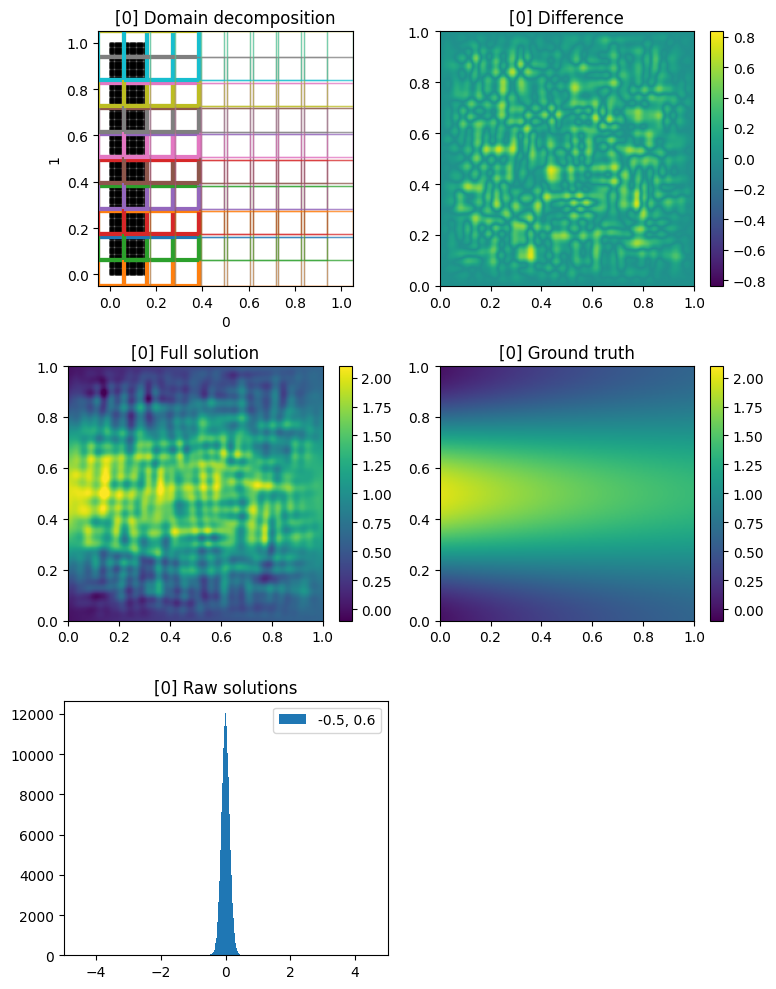

(3, 2) 2
True


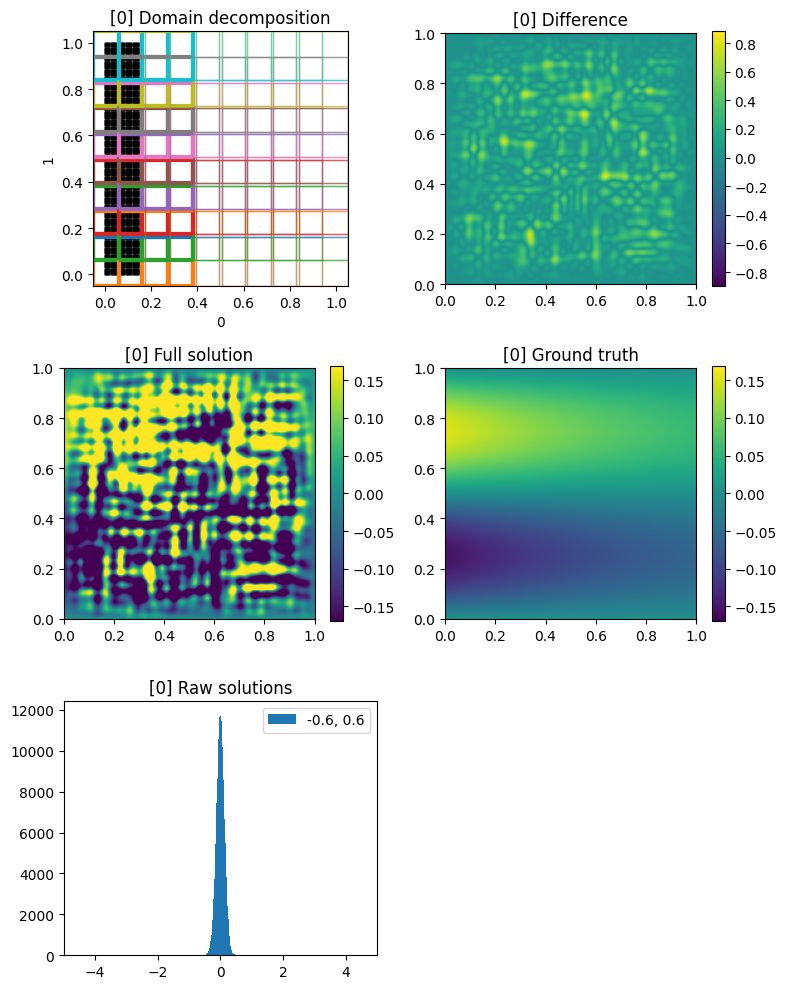

(3, 2) 2
True


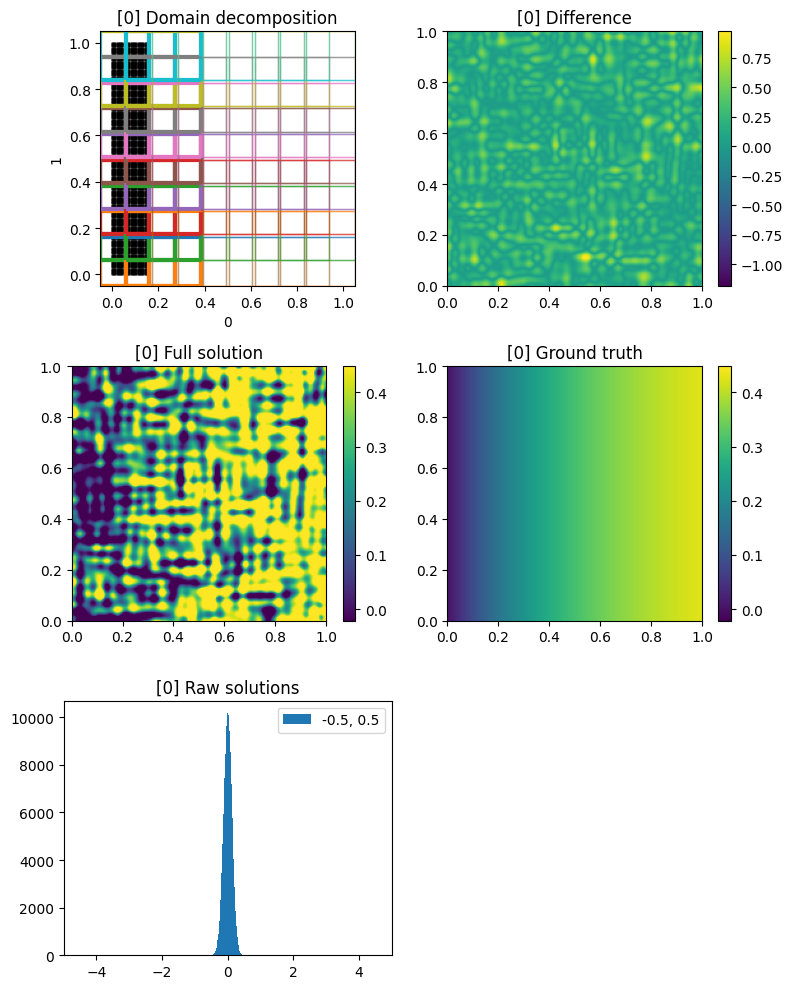

[INFO] 2025-03-28 02:16:37 - [i: 1000/50000] loss: 3.6227 rate: 80.1 elapsed: 0.00 hr test
[INFO] 2025-03-28 02:16:42 - [i: 2000/50000] loss: 0.7909 rate: 206.1 elapsed: 0.01 hr test
[INFO] 2025-03-28 02:16:45 - [i: 2632/50000] Updating active inputs..
[INFO] 2025-03-28 02:16:45 - [i: 2632/50000] Average number of points/dimension in active subdomains: 55.50
[INFO] 2025-03-28 02:16:47 - [i: 2632/50000] Updating active inputs done (1.92 s)
[INFO] 2025-03-28 02:16:47 - [i: 2632/50000] Compiling update step..
[INFO] 2025-03-28 02:16:47 - x_batch
[INFO] 2025-03-28 02:16:47 - (11000, 2), float32, JVPTracer
[INFO] 2025-03-28 02:16:47 - x_take
[INFO] 2025-03-28 02:16:47 - (84000, 2), float32, JVPTracer
[INFO] 2025-03-28 02:16:47 - x_batch
[INFO] 2025-03-28 02:16:47 - (11000, 2), float32, JVPTracer
[INFO] 2025-03-28 02:16:47 - x_take
[INFO] 2025-03-28 02:16:47 - (84000, 2), float32, JVPTracer
[INFO] 2025-03-28 02:16:53 - [i: 2632/50000] Compiling done (5.47 s)
[INFO] 2025-03-28 02:16:55 - [i: 

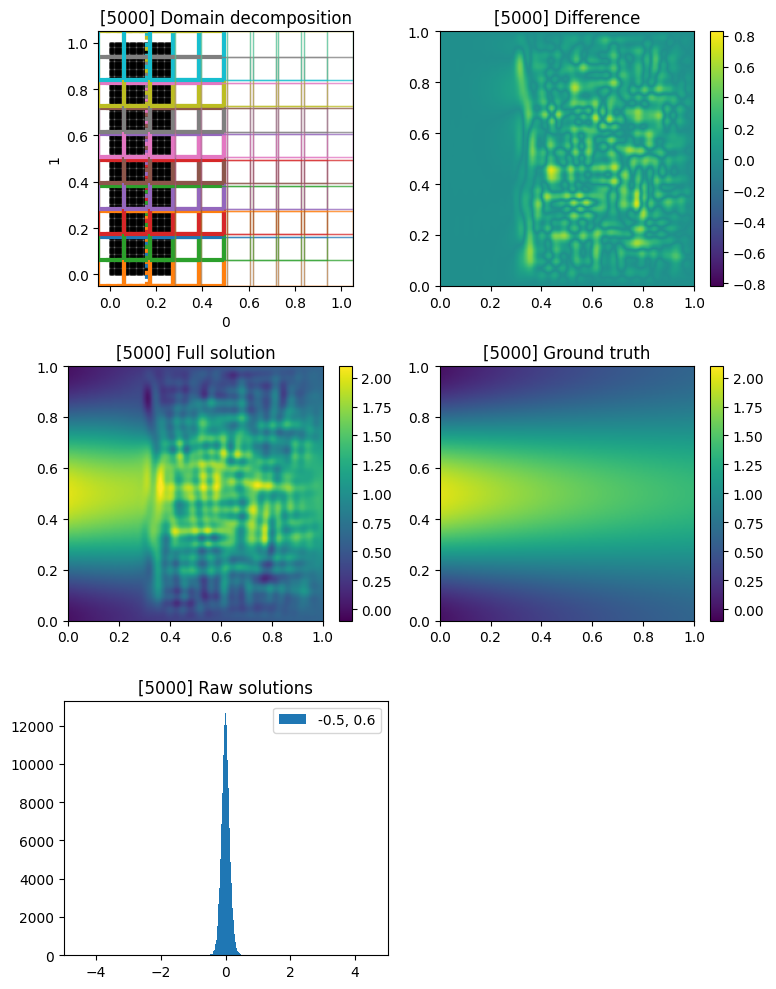

(3, 2) 2
True


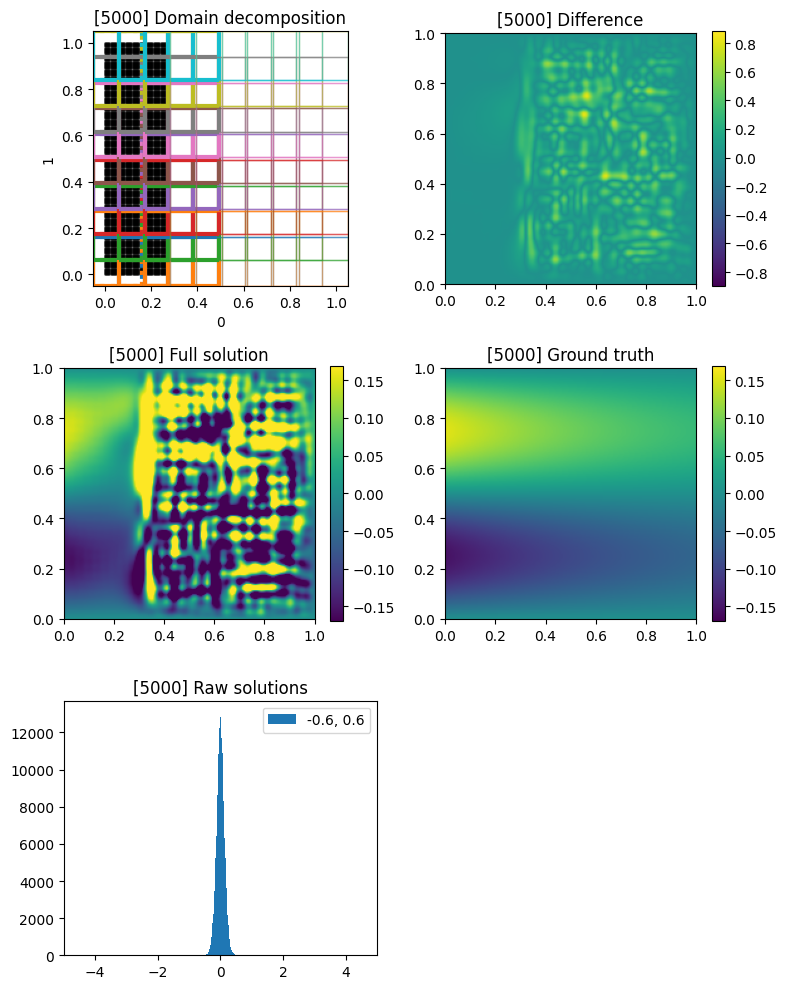

(3, 2) 2
True


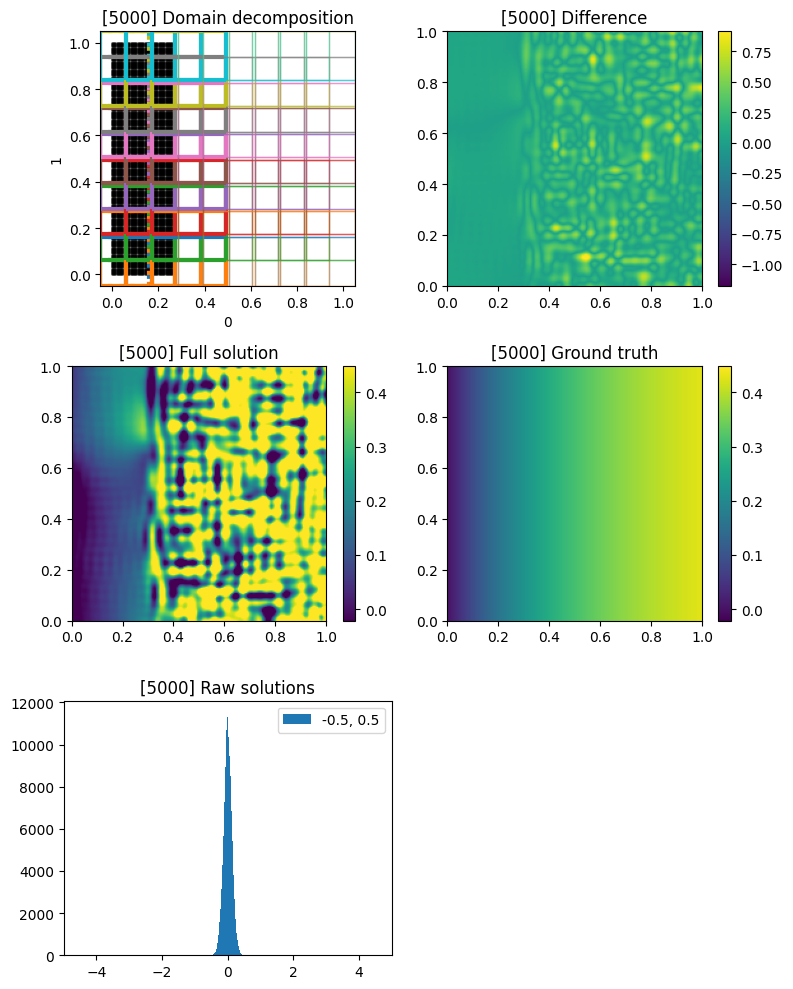

[INFO] 2025-03-28 02:17:18 - [i: 6000/50000] loss: 0.2333 rate: 137.0 elapsed: 0.02 hr test
[INFO] 2025-03-28 02:17:26 - [i: 7000/50000] loss: 0.1815 rate: 124.0 elapsed: 0.02 hr test
[INFO] 2025-03-28 02:17:33 - [i: 7895/50000] Updating active inputs..
[INFO] 2025-03-28 02:17:33 - [i: 7895/50000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-28 02:17:35 - [i: 7895/50000] Updating active inputs done (2.11 s)
[INFO] 2025-03-28 02:17:35 - [i: 7895/50000] Compiling update step..
[INFO] 2025-03-28 02:17:35 - x_batch
[INFO] 2025-03-28 02:17:35 - (12800, 2), float32, JVPTracer
[INFO] 2025-03-28 02:17:35 - x_take
[INFO] 2025-03-28 02:17:35 - (105280, 2), float32, JVPTracer
[INFO] 2025-03-28 02:17:35 - x_batch
[INFO] 2025-03-28 02:17:35 - (12800, 2), float32, JVPTracer
[INFO] 2025-03-28 02:17:35 - x_take
[INFO] 2025-03-28 02:17:35 - (105280, 2), float32, JVPTracer
[INFO] 2025-03-28 02:17:40 - [i: 7895/50000] Compiling done (4.97 s)
[INFO] 2025-03-28 02:17:41 - [

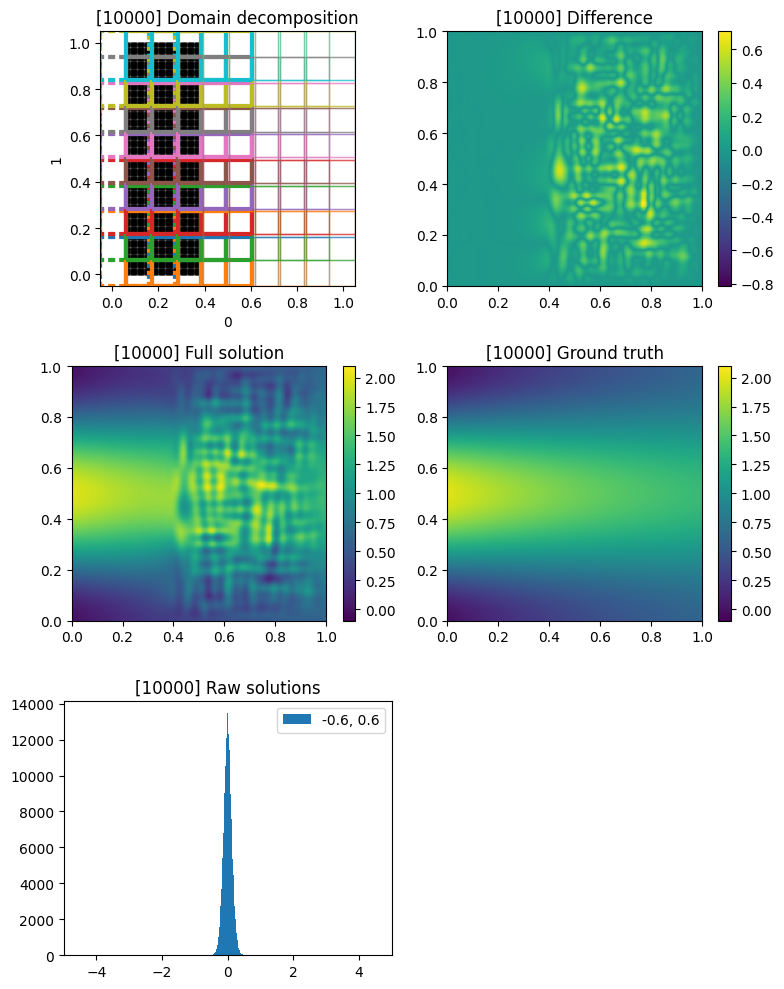

(3, 2) 2
True


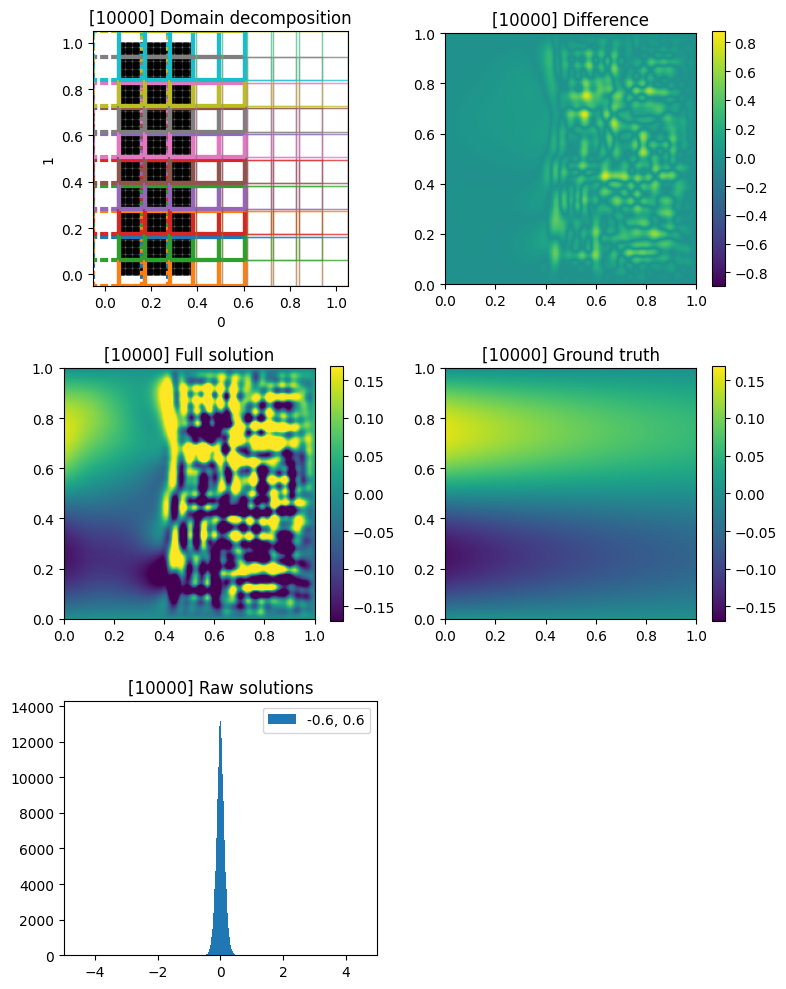

(3, 2) 2
True


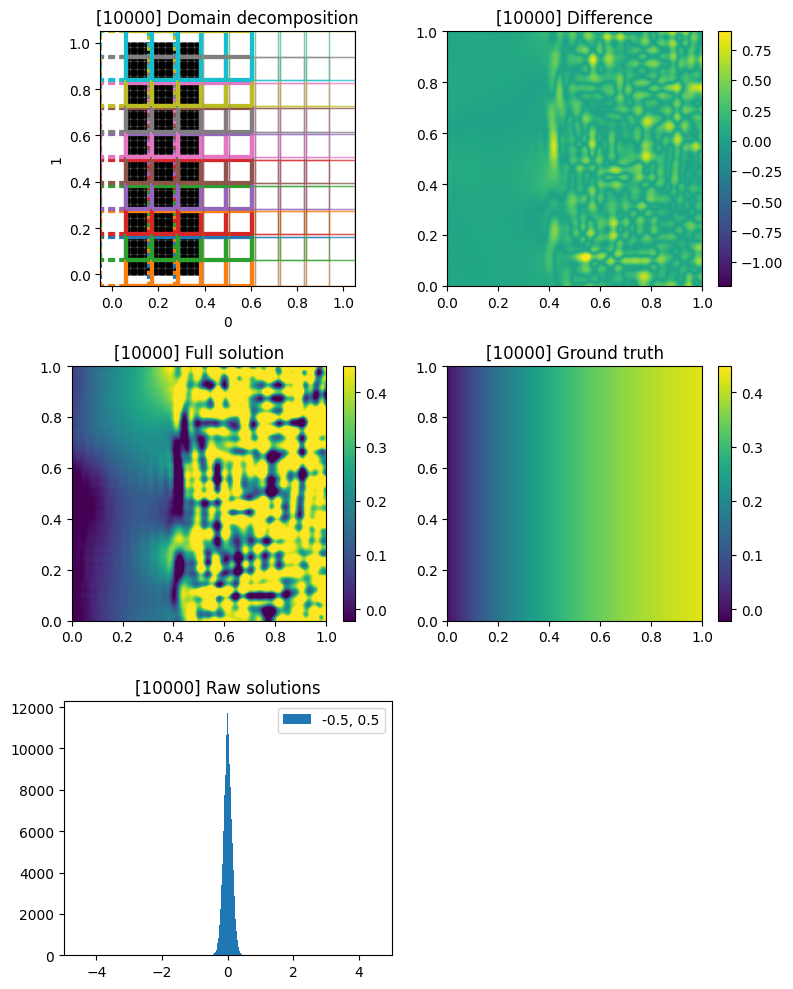

[INFO] 2025-03-28 02:18:16 - [i: 11000/50000] loss: 0.0963 rate: 91.5 elapsed: 0.03 hr test
[INFO] 2025-03-28 02:18:27 - [i: 12000/50000] loss: 0.0736 rate: 91.4 elapsed: 0.03 hr test
[INFO] 2025-03-28 02:18:38 - [i: 13000/50000] loss: 0.0623 rate: 92.4 elapsed: 0.04 hr test
[INFO] 2025-03-28 02:18:40 - [i: 13158/50000] Updating active inputs..
[INFO] 2025-03-28 02:18:40 - [i: 13158/50000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-28 02:18:40 - [i: 13158/50000] Updating active inputs done (0.26 s)
[INFO] 2025-03-28 02:18:40 - [i: 13158/50000] Compiling update step..
[INFO] 2025-03-28 02:18:40 - [i: 13158/50000] Compiling done (0.05 s)
[INFO] 2025-03-28 02:18:50 - [i: 14000/50000] loss: 0.2521 rate: 88.7 elapsed: 0.04 hr test
[INFO] 2025-03-28 02:19:01 - [i: 15000/50000] loss: 0.1004 rate: 90.7 elapsed: 0.04 hr test
(40000, 2) (40000, 3) (40000, 3) (313600, 3) (313600, 1) (313600, 3) (12800, 2) (200, 200)
(3, 2) 2
True


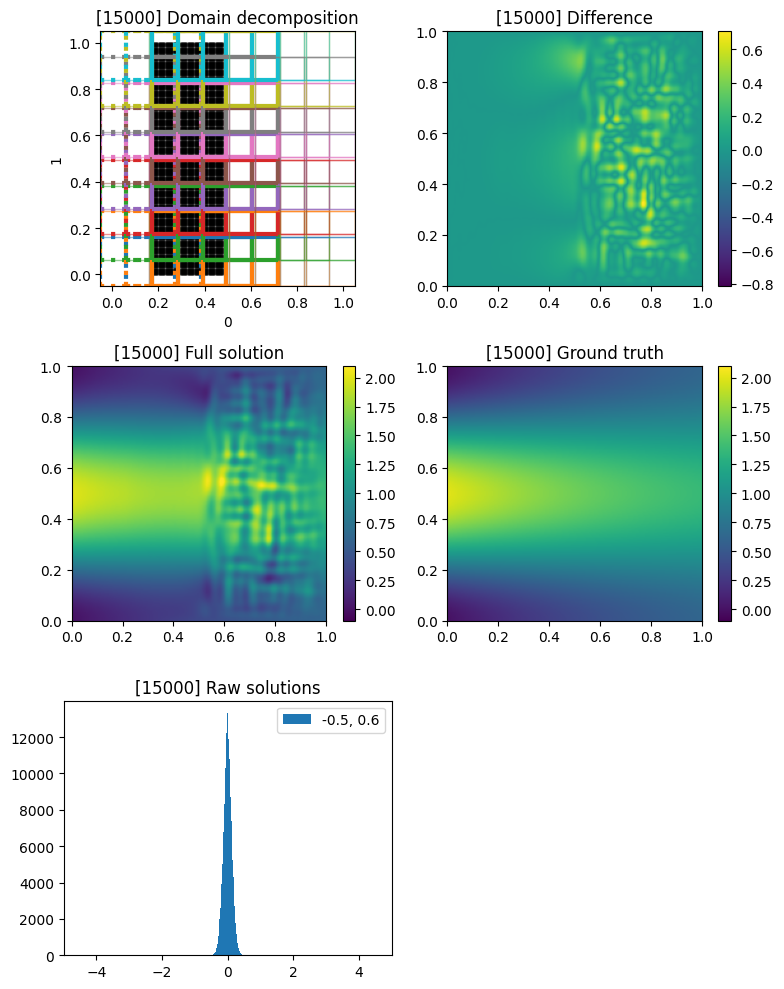

(3, 2) 2
True


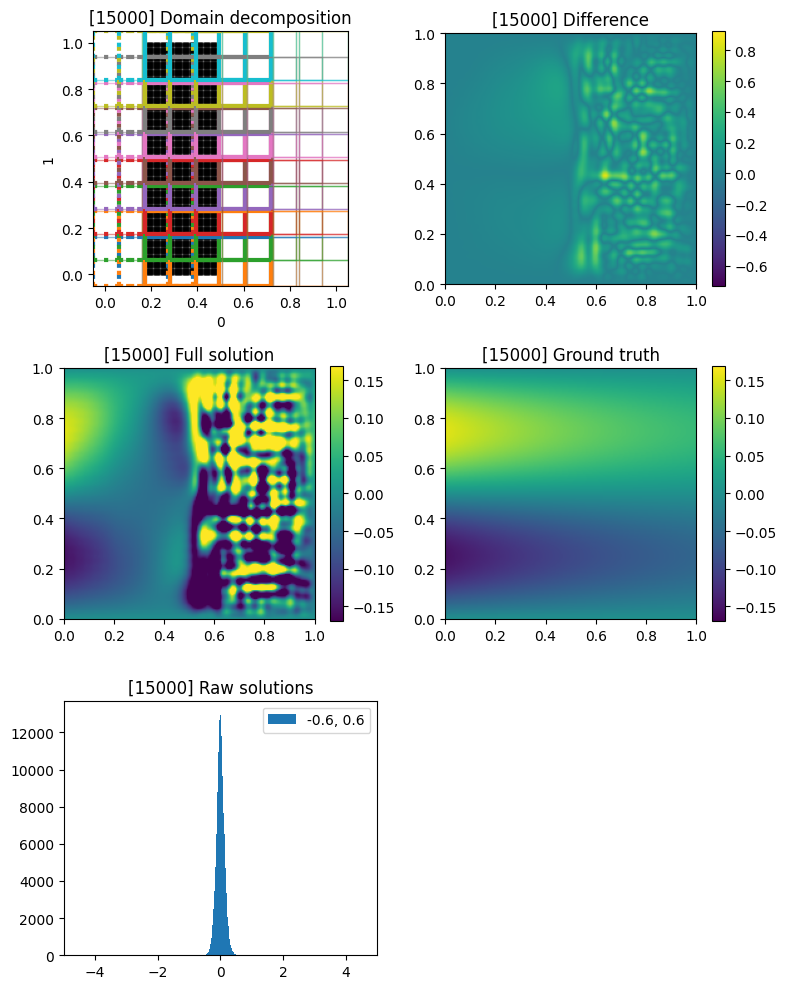

(3, 2) 2
True


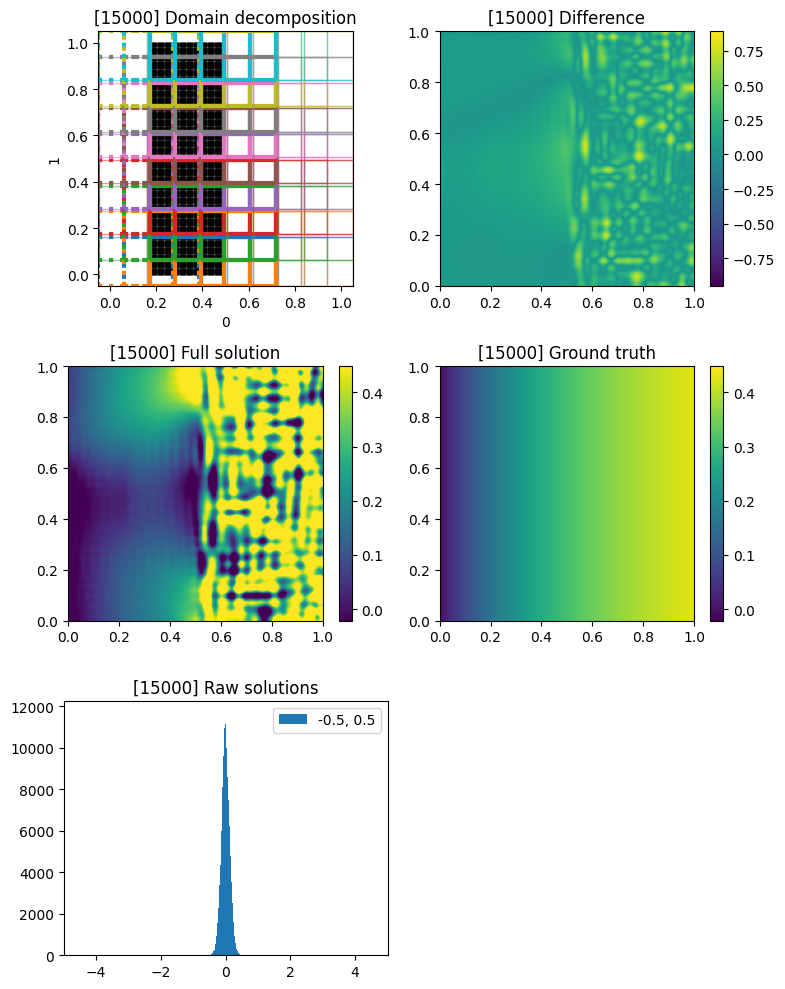

[INFO] 2025-03-28 02:19:14 - [i: 16000/50000] loss: 0.0528 rate: 90.4 elapsed: 0.05 hr test
[INFO] 2025-03-28 02:19:24 - [i: 17000/50000] loss: 0.0336 rate: 103.7 elapsed: 0.05 hr test
[INFO] 2025-03-28 02:19:35 - [i: 18000/50000] loss: 0.0258 rate: 91.3 elapsed: 0.05 hr test
[INFO] 2025-03-28 02:19:40 - [i: 18422/50000] Updating active inputs..
[INFO] 2025-03-28 02:19:40 - [i: 18422/50000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-28 02:19:40 - [i: 18422/50000] Updating active inputs done (0.13 s)
[INFO] 2025-03-28 02:19:40 - [i: 18422/50000] Compiling update step..
[INFO] 2025-03-28 02:19:40 - [i: 18422/50000] Compiling done (0.07 s)
[INFO] 2025-03-28 02:19:46 - [i: 19000/50000] loss: 0.6813 rate: 94.3 elapsed: 0.06 hr test
[INFO] 2025-03-28 02:19:57 - [i: 20000/50000] loss: 0.2932 rate: 94.8 elapsed: 0.06 hr test
(40000, 2) (40000, 3) (40000, 3) (313600, 3) (313600, 1) (313600, 3) (12800, 2) (200, 200)
(3, 2) 2
True


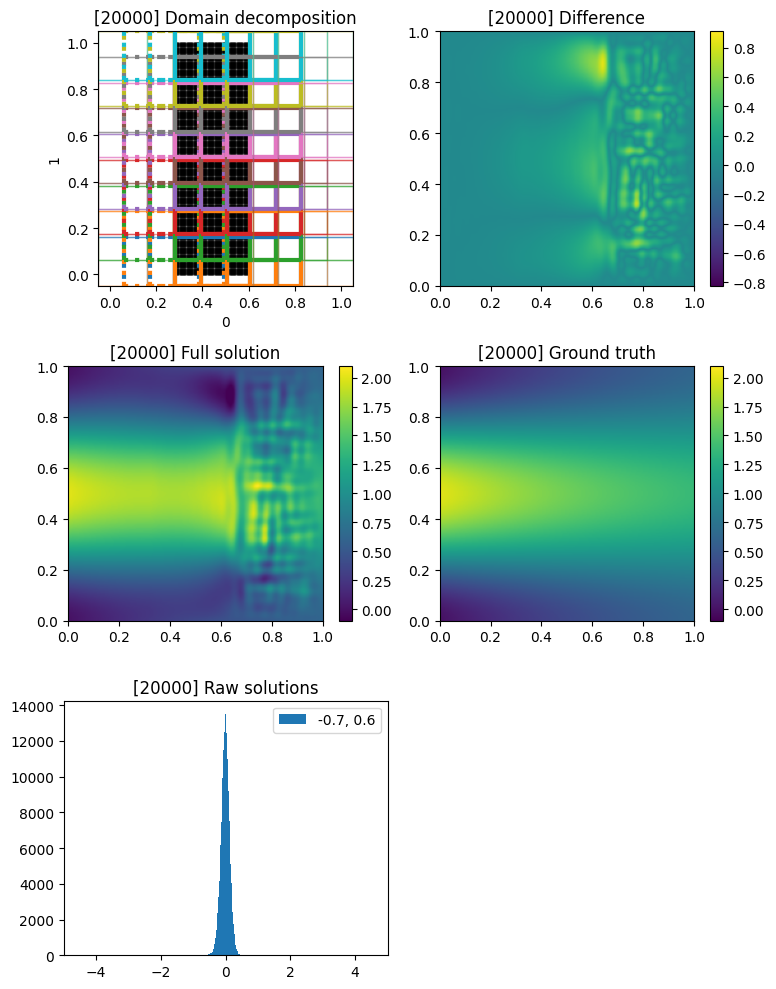

(3, 2) 2
True


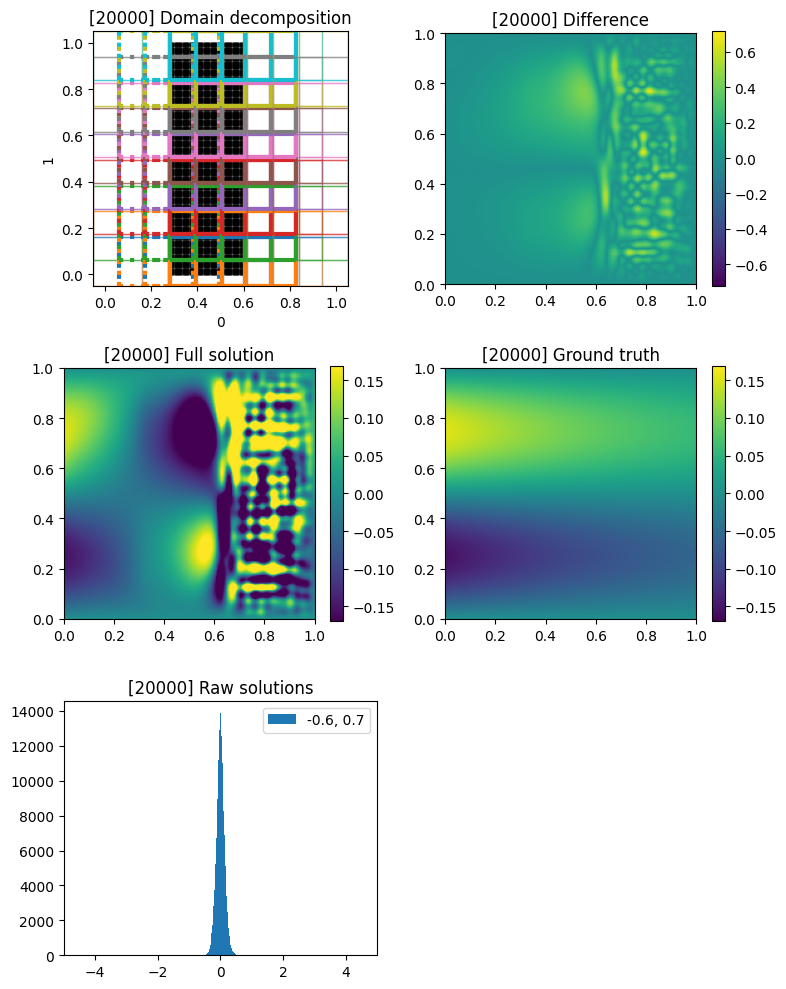

(3, 2) 2
True


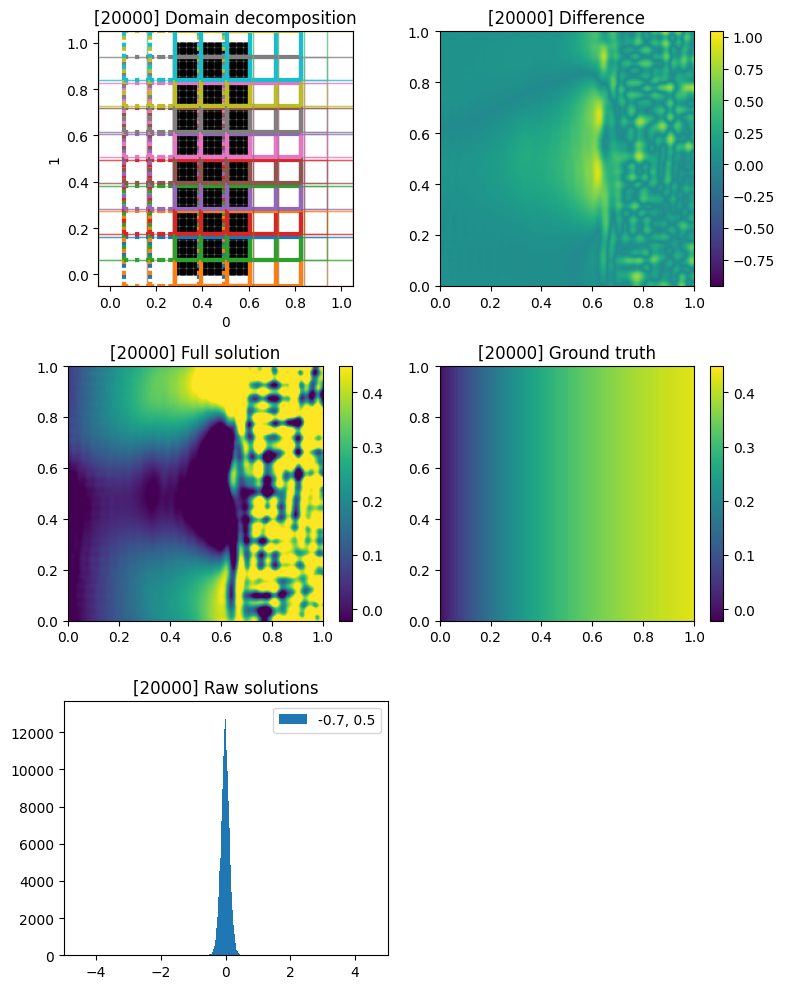

[INFO] 2025-03-28 02:20:09 - [i: 21000/50000] loss: 0.1418 rate: 95.8 elapsed: 0.06 hr test
[INFO] 2025-03-28 02:20:21 - [i: 22000/50000] loss: 0.0760 rate: 91.6 elapsed: 0.07 hr test
[INFO] 2025-03-28 02:20:32 - [i: 23000/50000] loss: 0.0535 rate: 91.6 elapsed: 0.07 hr test
[INFO] 2025-03-28 02:20:39 - [i: 23685/50000] Updating active inputs..
[INFO] 2025-03-28 02:20:40 - [i: 23685/50000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-28 02:20:40 - [i: 23685/50000] Updating active inputs done (0.12 s)
[INFO] 2025-03-28 02:20:40 - [i: 23685/50000] Compiling update step..
[INFO] 2025-03-28 02:20:40 - [i: 23685/50000] Compiling done (0.06 s)
[INFO] 2025-03-28 02:20:43 - [i: 24000/50000] loss: 3.9682 rate: 91.9 elapsed: 0.07 hr test
[INFO] 2025-03-28 02:20:54 - [i: 25000/50000] loss: 1.4986 rate: 95.4 elapsed: 0.08 hr test
(40000, 2) (40000, 3) (40000, 3) (313600, 3) (313600, 1) (313600, 3) (12800, 2) (200, 200)
(3, 2) 2
True


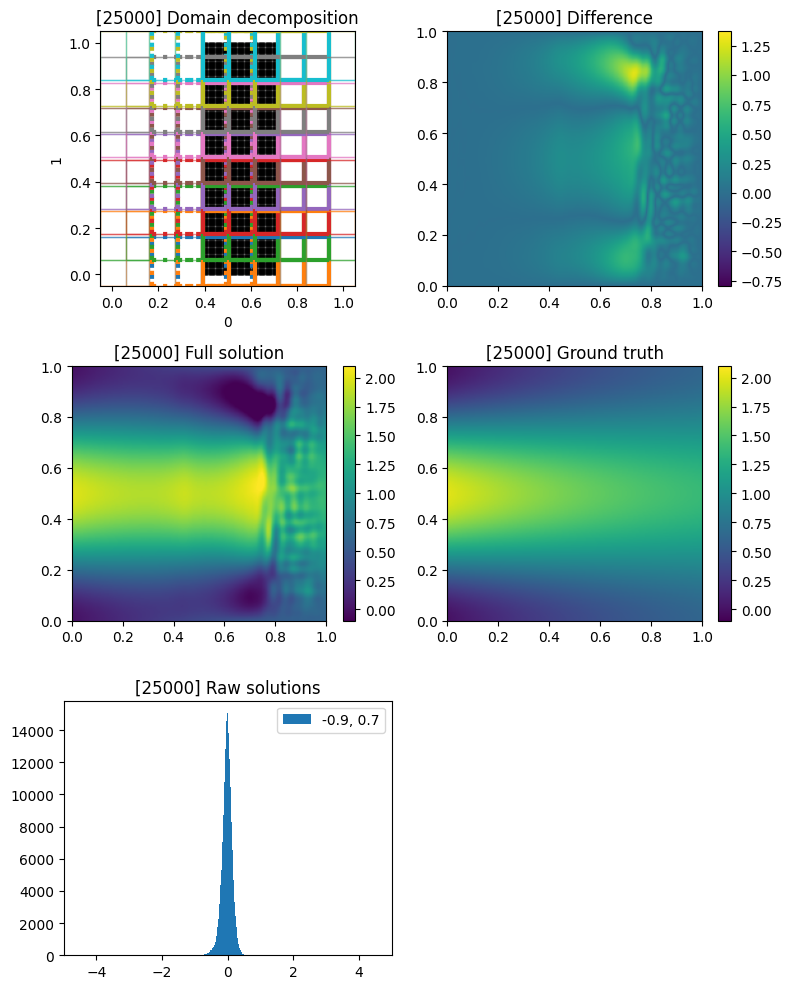

(3, 2) 2
True


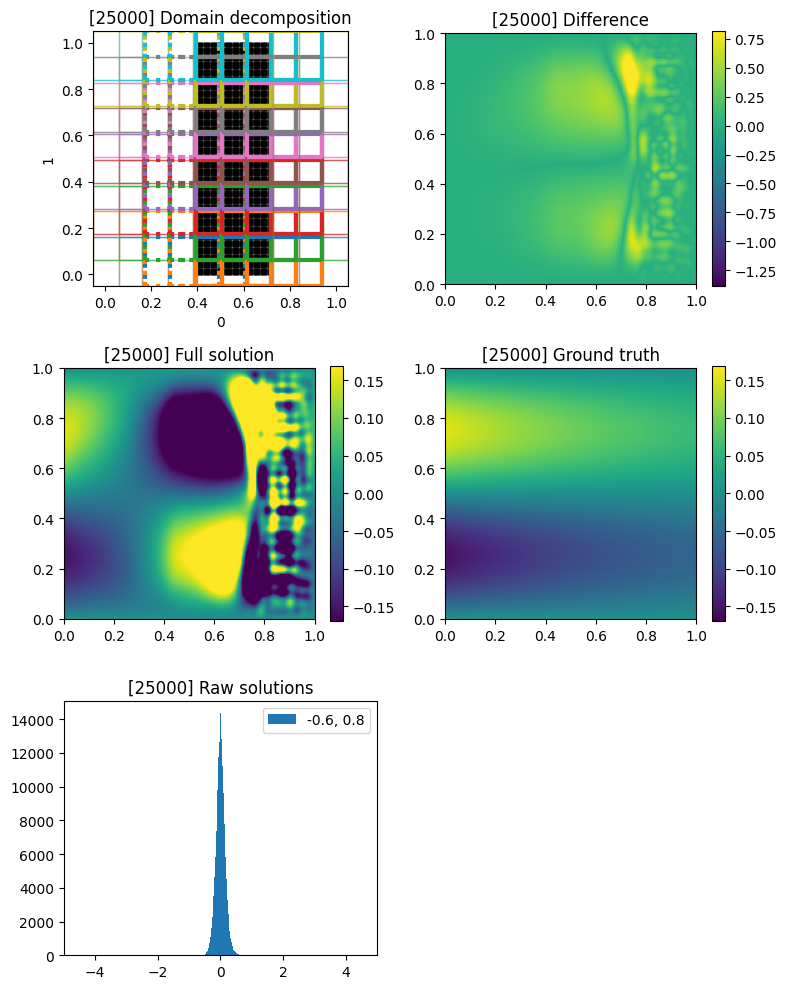

(3, 2) 2
True


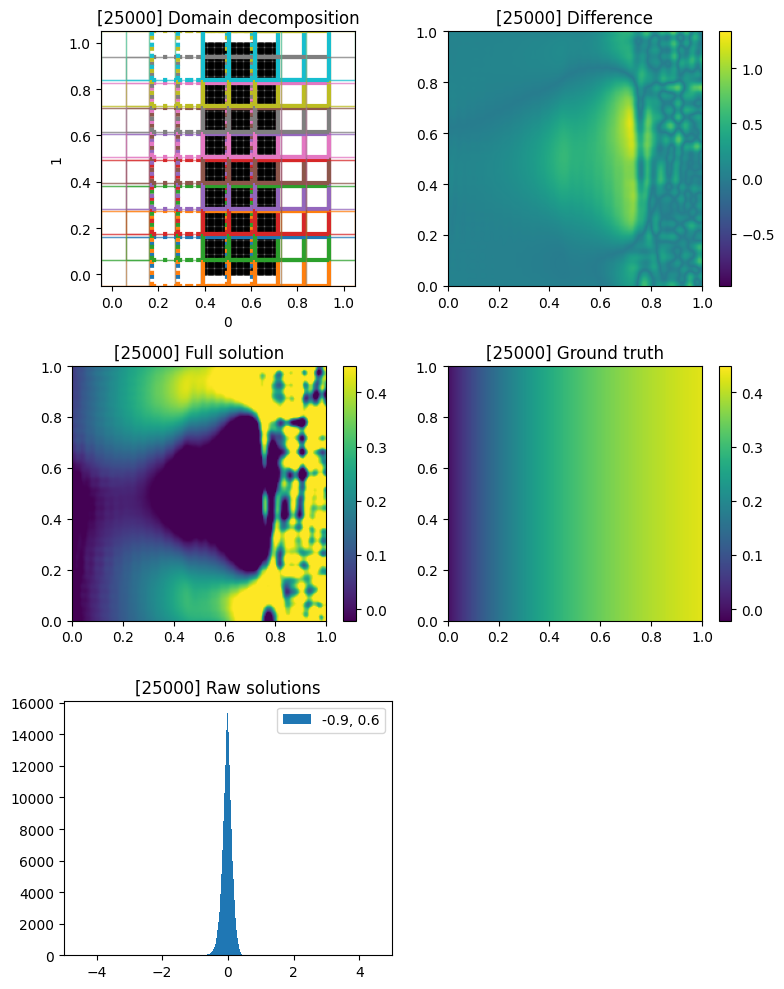

[INFO] 2025-03-28 02:21:06 - [i: 26000/50000] loss: 0.8612 rate: 100.8 elapsed: 0.08 hr test
[INFO] 2025-03-28 02:21:17 - [i: 27000/50000] loss: 0.4824 rate: 94.6 elapsed: 0.08 hr test


KeyboardInterrupt: 

In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

x_min, x_max = 0., 1.
y_min, y_max = 0., 1.
subdomain_xs=[np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_min,y_min]),
        xmax=np.array([x_max,y_max])
        ),
    problem=KovasznayFlow,
    problem_init_kwargs = dict(
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 32, 2),
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=3,
        degree=20
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=1,
    ),
    optimiser_kwargs = dict(
        learning_rate=0.0001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=50000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()